# Understanding Group Sequential Testing

*How to run valid experiments, with unplanned peeking and early stopping.*

A/B tests are the golden standard of causal inference because they allow us to make valid causal statements under minimal assumptions, thanks to **randomization**. In fact, by randomly assigning a **treatment** (a drug, ad, product, ...), we are able to compare the **outcome** of interest (a disease, firm revenue, customer satisfaction, ...) across **subjects** (patients, users, customers, ...) and attribute the average difference in outcomes to the causal effect of the treatment.

The implementation of an A/B test is usually not instantaneous, especially in online settings. Often users are treated **live** or in **batches**. In these settings, one can look at the data before the data collection is completed, one or multiple times. This phenomenon is called **peeking**. While looking is not problematic in itself, with looking comes the temptation to draw conclusions from intermediate results. However, using standard testing procedures when peeking can lead to **misleading conclusions**. 

The **solution** to peeking is to adjust our testing procedure accordingly. The most famous and traditional approach is the so-called **Sequential Probability Ratio Test (SPRT)**, which dates back to the Second World War. If you want to know more about the test and its fascinating history, I wrote a blog post about it.

https://towardsdatascience.com/954506cec665

The main **advantage** of the Sequential Probability Ratio Test (SPRT) is that it guarantees the smallest possible sample size, given a target confidence level and power. However, the **main problem** with the SPRT is that it might continue indefinitely. As you can imagine, this is a non-irrelevant problem in an applied setting with deadlines and budget constraints. In this article, we will explore an **alternative method** that allows *any* amount of intermediate peeks at the data, at *any* point of the data collection: **Group Sequential Testing**.

## Simulation

Let's start with some simulated **data**. To keep the code as light as possible, I will abstract away from the experimental setting, and directly work with data coming out of a **normal distribution**. However, you can think of it as the distribution of the average treatment effect in a standard A/B test. The normal distribution is an asymptotic approximation based on the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem).

Before generating the data,  I import the relevant libraries and my plotting theme from [src.theme](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/theme.py).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.theme import *
import numpy as np
import pandas as pd
import scipy as sp

Let's assume the true data generating process is indeed a normal distribution with **mean** *μ=1* and **standard deviation** *σ=5.644*. In the context of an A/B test, ou can think of this as a positive average treatment effect with standard deviation more than 5 times larger than the effect.

In [3]:
mu = 1
sigma = 5.644

We would like to build a two-sided test with *95%* confidence and *80%* power. Therefore our false positive error rate will be *α=0.05* and our false negative error rate will be *β=0.2*.

In [4]:
alpha = 0.05
beta = 0.2

We can now compute the required sample size for the experiment, under the assumption of an average treatment effect of *1* and a standard deviation of *5.664*. Since we have abstracted from the two-group comparison, the formula for the power calculation is

$$
N = \Big( 2 \sigma  \frac{ z_{1-\alpha/2} + z_{1-\beta} }{ \mu } \Big)^2
$$

where *z*s are the quantiles of a standard normal distribution, evaluated at *1-α/2* and *1-β*, respectively.

In [5]:
ppf = sp.stats.norm(0, 1).ppf
cdf = sp.stats.norm(0, 1).cdf
z_alpha = ppf(1 - alpha/2)
z_beta = ppf(1 - beta)
N = int((2 * sigma * (z_alpha + z_beta) / mu)**2)
N

1000

We need *N=1000* observations to achieve our target confidence level of *95%* and power of *80%*.

We can now draw the simulated data. Since we will often compare the results across different simulations, we draw *K=10,000* sequences of *N=1,000* data point.

In [6]:
K = 10_000
np.random.seed(2)
obs = np.random.normal(mu, sigma, size=(N, K))

We are now ready to investigate peeking and group sequential testing.

## Peeking

What happens if we **peek** at the data, **before the end** of the experiment?

Let's suppose for example that we have a look at the data every *50* observations, starting at *100*. One reason could be that the data arrives in batches, or that we peek every day as soon as we start working.

In [7]:
N_peek = np.arange(100, N+1, 50, dtype=int)
N_peek

array([ 100,  150,  200,  250,  300,  350,  400,  450,  500,  550,  600,
        650,  700,  750,  800,  850,  900,  950, 1000])

Looking at the data of course is not a problem *per-se*. However, we might be tempted to **draw conclusions**, given what we observe. Suppose that our *naive* experimentation platform continuously reports the latest average, standard deviation and confidence interval, where the confidence interval is simply computed as

$$
\text{CI}_n = \Big [ \hat{\mu}_n - z_{1-\alpha/2} \frac{\hat{\sigma}_n}{\sqrt{n}} \quad ; \quad \hat{\mu}_n - z_{1-\alpha/2} \frac{\hat{\sigma}_n}{\sqrt{n}} \Big]
$$

where *n* is the number of samples, *μ̂ₙ* is the estimated sample average after *n* samples, *σ̂ₙ* is the estimated standard deviation after *n* samples, *α* is the significance level, and *z* is the *1-α/2* quantile of a standard normal distribution.

In [8]:
def select_alpha_naive(n, N, N_peek, alpha):
    return alpha

Suppose that we decide to **stop the experiment** as soon as we get one significant result.

Let's compute the confidence intervals that we would observe at each peeking point.

In [80]:
def compute_intervals(select_alpha, obs, N_peek, alpha=0.05, **kwargs):
    # Compute rolling mean and standard deviation
    N, K = np.shape(obs)
    ns = np.reshape(np.arange(1, N+1), (-1, 1))
    means = np.cumsum(obs, axis=0) / ns
    stdevs = np.sqrt(np.cumsum((obs - means)**2, axis=0) / ns)

    # Compute intervals at each peeking time
    df_intervals = pd.DataFrame({"k": range(K)})
    df_intervals["rejected_0"] = False
    df_intervals["rejected_1"] = False
    df_intervals["length"] = max(N_peek)
    for t, n in enumerate(N_peek):
        df_intervals[f"mean{n}"] = means[n-1, :]
        df_intervals[f"width{n}"] = ppf(1 - select_alpha(n, N, N_peek, alpha, **kwargs)/2) * stdevs[n-1, :] / np.sqrt(n)
        df_intervals[f"lowerb{n}"] = means[n-1, :] - df_intervals[f"width{n}"]
        df_intervals[f"upperb{n}"] = means[n-1, :] + df_intervals[f"width{n}"]
        df_intervals[f"coverage{n}"] = (df_intervals[f"lowerb{n}"] <= mu) & (df_intervals[f"upperb{n}"] >= mu)
        df_intervals["rejected_0"] = df_intervals["rejected_0"] | (df_intervals[f"lowerb{n}"] >= 0) | (df_intervals[f"upperb{n}"] <= 0)
        df_intervals[f"power{n}"] = df_intervals["rejected_0"]
        df_intervals["rejected_1"] = df_intervals["rejected_1"] | ~df_intervals[f"coverage{n}"]
        df_intervals[f"falsep{n}"] = df_intervals["rejected_1"]
        df_intervals["length"] = np.minimum(df_intervals["length"], n) * df_intervals["rejected_0"] + max(N_peek) * (1 - df_intervals["rejected_0"])
    return df_intervals

In [10]:
dfi_naive = compute_intervals(select_alpha_naive, obs, N_peek)

What do these averages and confidence intervals look over time? In the figure below, I plot the cumulative average over the data collection, together with the confidence intervals at each peeking time.

In [11]:
def plot_peeking(dfi, obs, k=1):
    ns = np.reshape(np.arange(1, N+1), (-1, 1))
    means = np.cumsum(obs, axis=0) / ns
    # Plot
    fig, ax = plt.subplots()
    for n in N_peek:
        color = "C1" if dfi[f"width{n}"][k] > dfi[f"mean{n}"][k] else "C2"
        ax.errorbar(x=[n-1], y=dfi[f"mean{n}"][k], yerr=dfi[f"width{n}"][k], c=color, lw=0, elinewidth=2, capsize=6, marker="o", markersize=6)
    sns.lineplot(x=range(30, N), y=means[:,k][30:], lw=3, ax=ax);
    ax.axhline(y=0, lw=1)
    ax.set(xlim=(20, N+10), xlabel="n", title="Average Effect and Confidence Intervals");

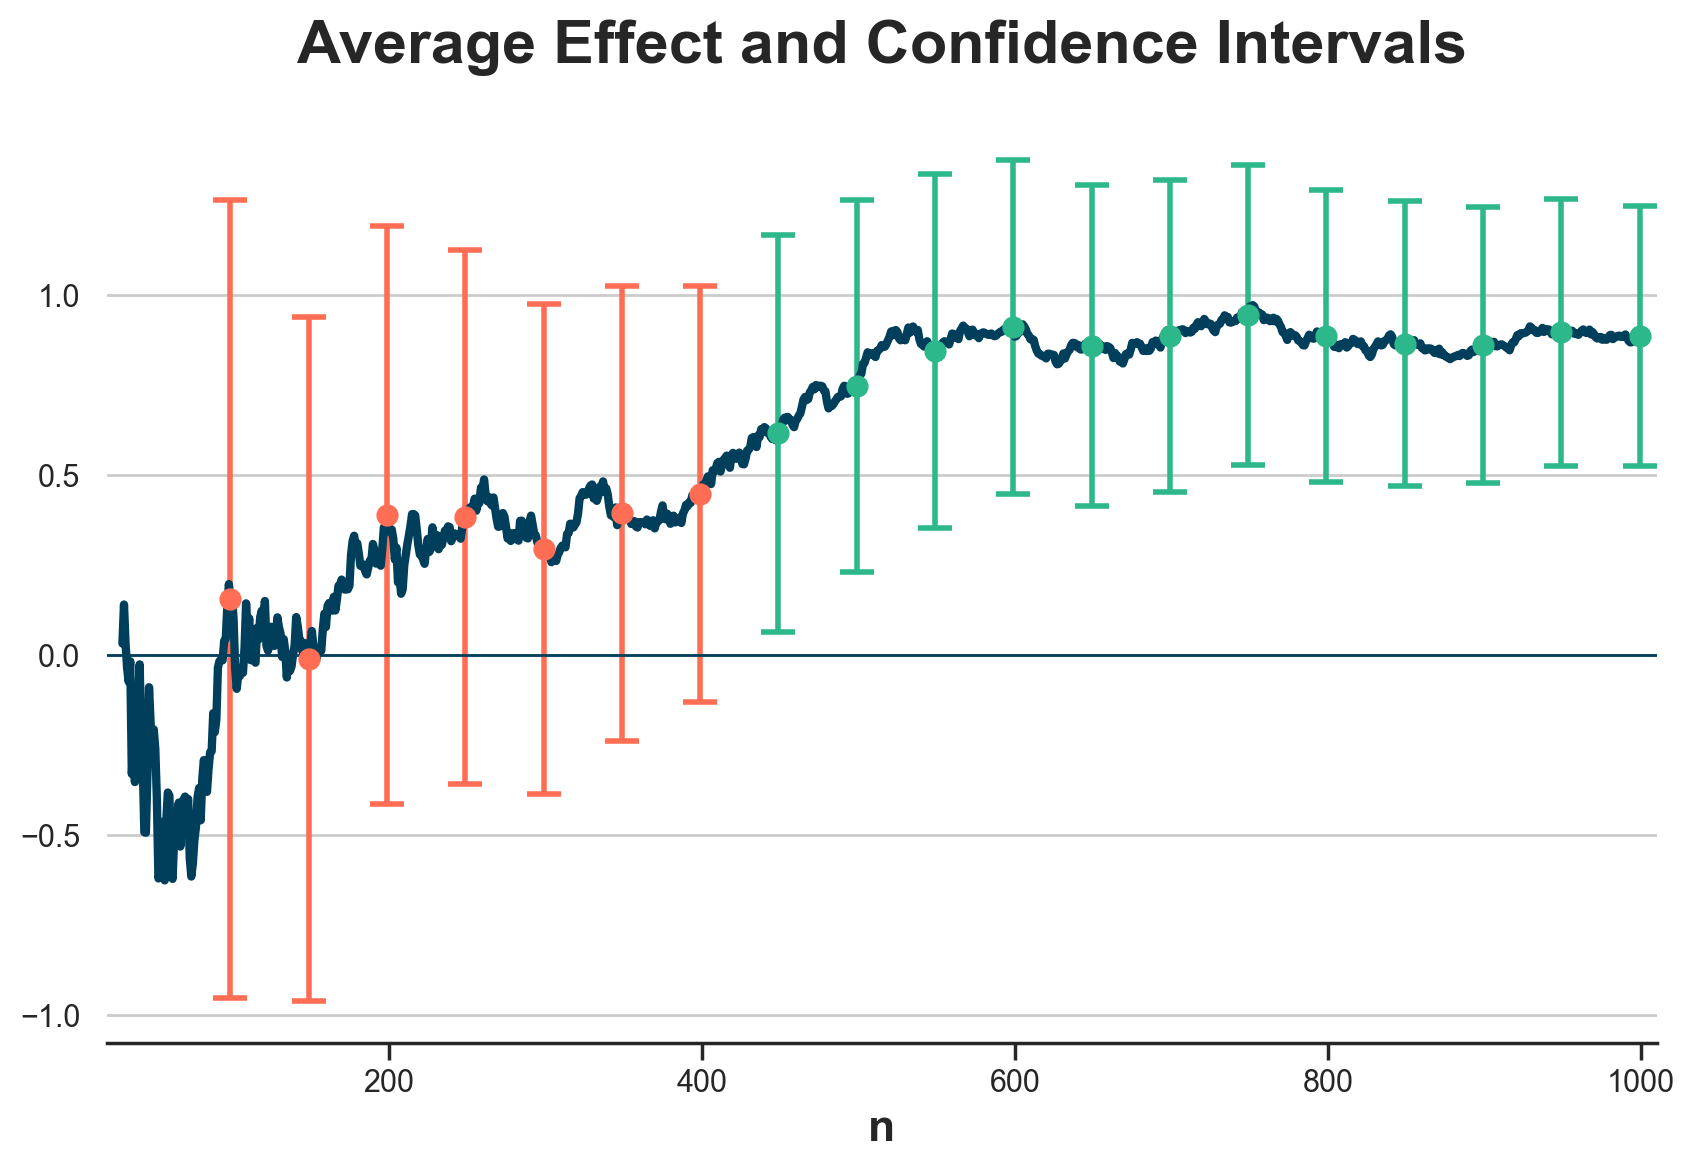

In [12]:
plot_peeking(dfi_naive, obs)

As we can see, the first *7* times we look at the data the confidence intervals cross the zero line and hence we do not reject the null hypothesis of zero mean. I have highlighted these confidence intervals in orange. However, in the fourth look at the data, at *450* observations, the confidence interval does not cross the zero line and hence we **reject the null hypothesis** of no effect and we stop the experiment.

The problem of this procedure is very similar to **multiple hypothesis testing**: we are building the confidence intervals for a single look at the data and therefore a *single* decision, but instead we are making *multiple* decisions. In fact we have *decided* not to stop the experiment before reaching *450* observations and we have stopped it at *450*.

What are the **consequences** of peeking and early stopping? Let's have a look at what would happen if we were to repeat this experiment multiple times. We will now plot the confidence intervals for *100* different simulations at three different points in time: after *200*, *400* and *600* observations are collected. Note that these correspond to the *3rd*, *7th* and *11th* peek at the data, respectively.

In [13]:
N_plot = [200, 400, 600]

In [14]:
def plot_intervals(dfi, N_plot, power_coverage: str):
    fig, (axes) = plt.subplots(1, len(N_plot))
    x = 0 if power_coverage == "power" else mu
    df_short = dfi.iloc[:100, :].copy()
    
    # Plot intervals
    for k, i, ax in zip(range(len(N_plot)), N_plot, axes):
        # Plot intervals
        ax.errorbar(x=df_short[f"mean{i}"], y=df_short["k"], xerr=df_short[f"width{i}"], 
                     fmt="", lw=0, alpha=0.3, elinewidth=1)
        ax.axvline(x=x, lw=1, ls="--", c="k")
    
        # Add wrong intervals
        temp = df_short.loc[df_short[f"{power_coverage}{i}"] == False]
        ax.errorbar(x=temp[f"mean{i}"], y=temp["k"], xerr=temp[f"width{i}"], 
                     fmt="", lw=0, alpha=1, elinewidth=2)
    
        # Rest
        ax.set(xlim=(-0.2, 2.2))
        ax.set_title(f"n = {i}", pad=10)
        ax.title.set_size(14)
        if k > 0:
            ax.set_yticks([])
    plt.suptitle(power_coverage.capitalize(), y=1.01);

The first thing that we are going to inspect is **coverage**: do the confidence intervals actually *cover* the true treatment effect, as they are supposed to? I highlight the confidence intervals that don't.

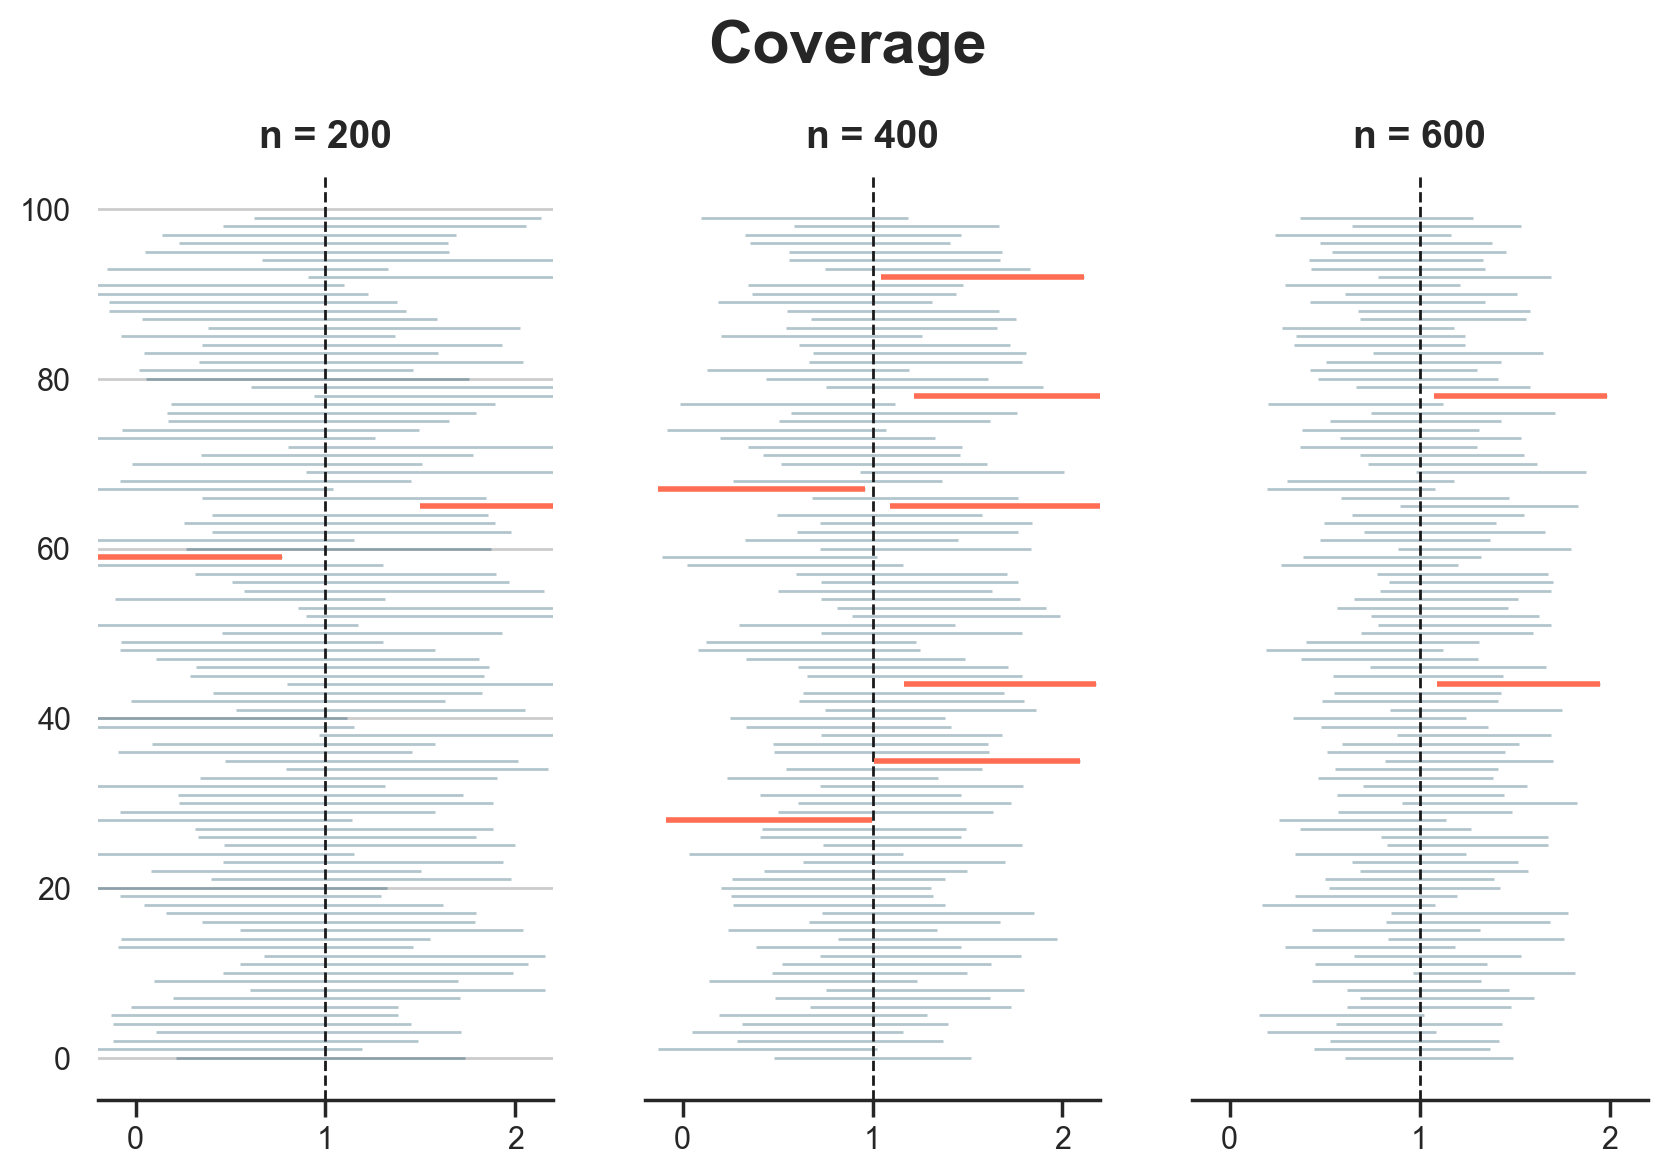

In [15]:
plot_intervals(dfi_naive, N_plot, "coverage")

It seems that our coverage is fine at each point in time. We have, respectively, *2*, *6*, and *2* simulations out of *100* in which the interval does not cover the true treatment effect, *μ=1*. This is expected since our *confidence level* *α=5%* and therefore we expect *on average* that *8* intervals out of *100* do not cover the true treatment effect.

Next, we investigate **power**: the ability of our estimator to detect an effect when there is indeed one. Remember that power is always *relative* to the effect size. However, we did our power calculations using the true effect so we expect the experiment to have the excepted power of *1-β=80%*.

Note that, since we are peeking, reject the null hypothesis and stop the experiment *as soon as* one test is significant. Therefore, in our case, power at a specific point in time is the probability of rejecting the null hypothesis with that test or *any* of the previous ones.

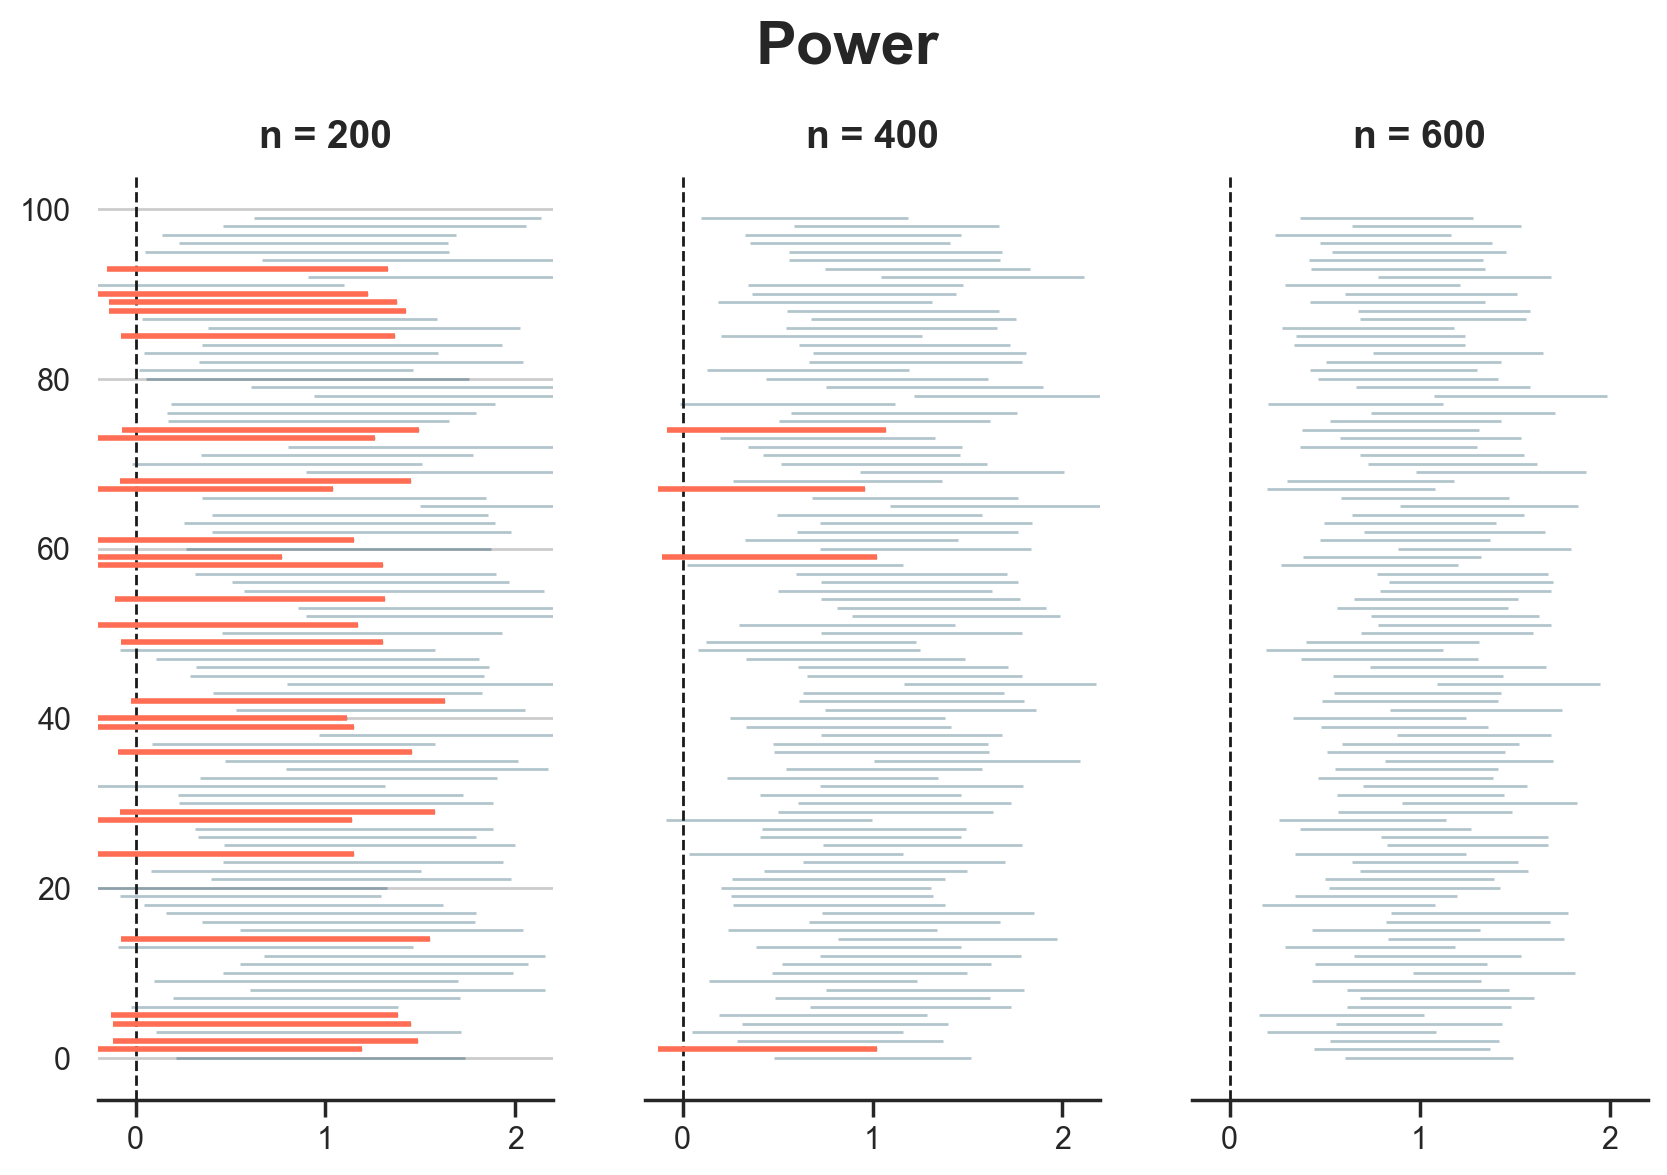

In [16]:
plot_intervals(dfi_naive, N_plot, "power")

As we can see, at *200* observations we already reject the null hypothesis of no effect (*μ=0*) in *72* simulations out of *100*, close to the target power of *80%*. However, at *400* observations we reject the null hypothesis in well over *80* simulations over *100*, suggesting that we could have run the experiment for a shorter amount of time.

It seems that so far everything is going great: our intervals cover the true effect and reject the null hypothesis even faster than expected. Let's check this for all the peeking stages and over *10,000* simulations. Let's also check a third metric: the **false positive** error rate. In order to compute that, we change the null hypothesis to *μ=1* and check how often we reject it. Again, since we are peeking multiple times, what counts is the rejection rate at a specific peeking stage or *any* of the previous ones. 

In [18]:
def check_performance(dfi):
    df_perf = dfi[list(dfi.filter(regex="coverage|power|falsep"))].copy()
    df_perf["idx"] = 1
    df_perf = df_perf.groupby("idx", as_index=False).mean()
    df_perf = pd.wide_to_long(df_perf, stubnames=["coverage", "power", "falsep"], i="idx", j="n").reset_index().drop(columns="idx")
    return df_perf

In [60]:
def plot_coverage_power(dfi, alpha=0.05, beta=0.8):
    df_perf = check_performance(dfi)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 3))
    
    # Plot Coverage
    sns.lineplot(df_perf, x="n", y="coverage", c="C0", ax=ax1)
    ax1.axhline(y=1-alpha, ls="--", lw=2, c="C0")
    ax1.set(title="Coverage", ylabel="", ylim=(0.89, 1.01))
    
    # Plot power
    sns.lineplot(df_perf, x="n", y="power", c="C1", ax=ax2)
    ax2.axhline(y=beta, ls="--", lw=2, c="C1")
    ax2.set(title="Power", ylabel="", ylim=(0.5, 1.05))

    # Plot false positives
    sns.lineplot(df_perf, x="n", y="falsep", c="C2", ax=ax3)
    ax3.axhline(y=alpha, ls="--", lw=2, c="C2")
    ax3.set(title="False Rejections", ylabel="", ylim=(-0.01, 0.24))    

In the figure below, I plot coverage, power and false rejection rate over *10,000* simulations at each peeking stage.

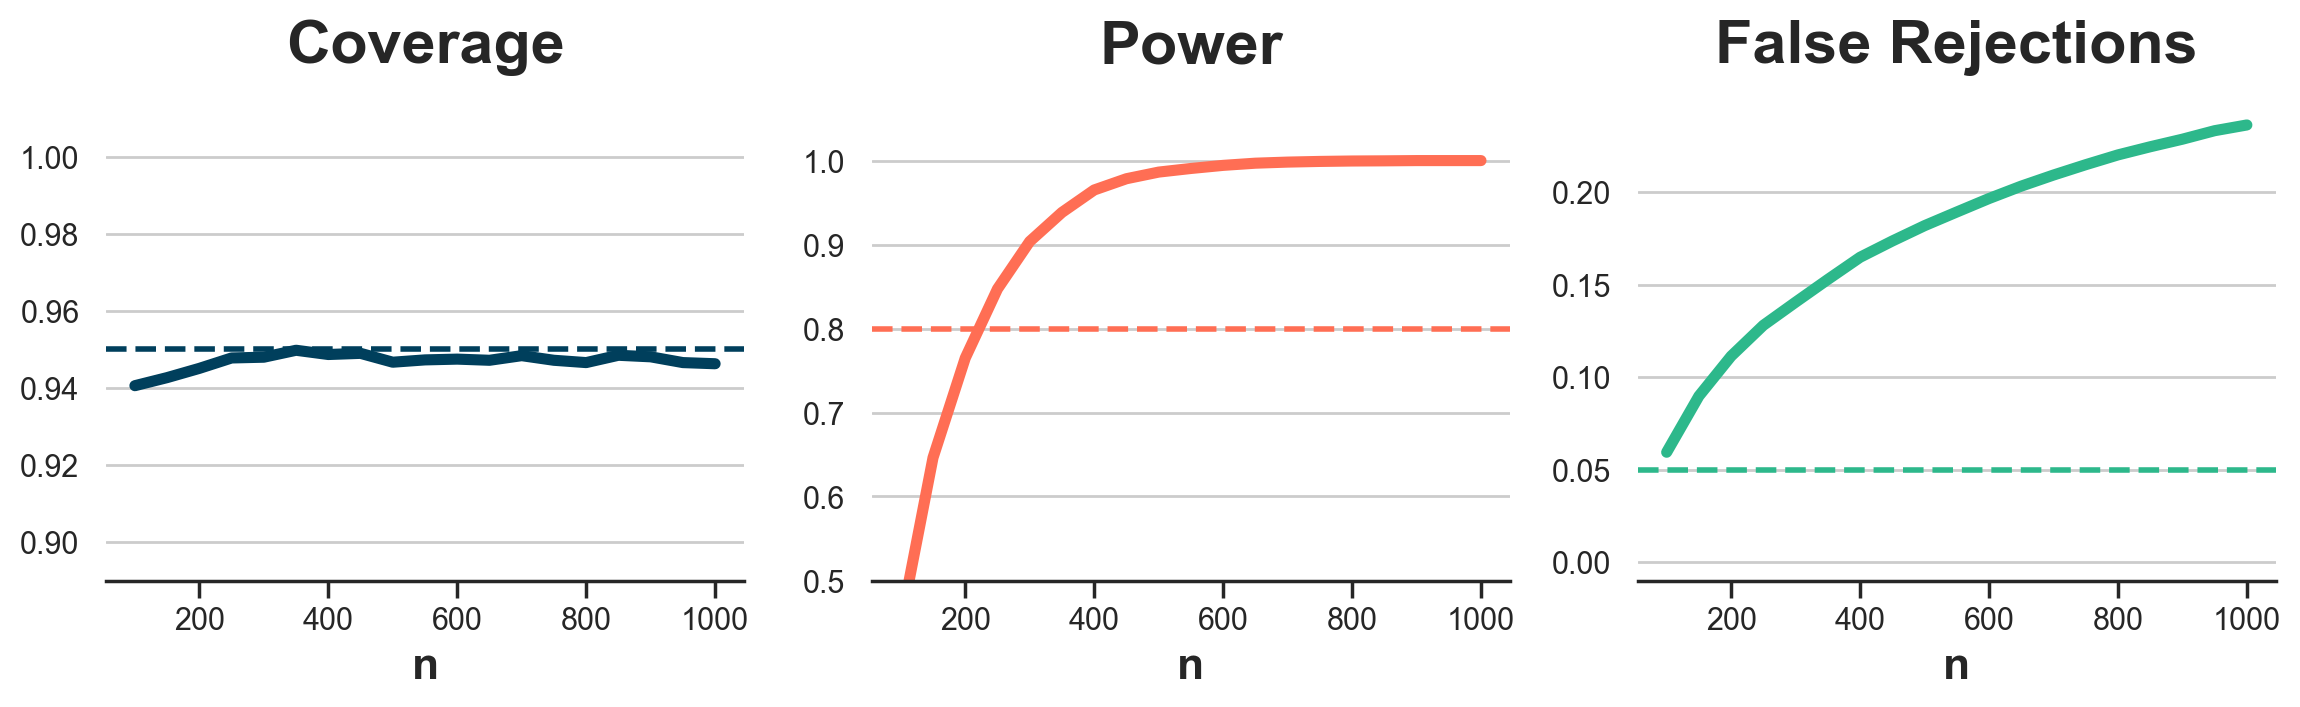

In [61]:
plot_coverage_power(dfi_naive)

Coverage seems indeed fair, if anything lightly lower than the *95%* target. Power is above *80%* starting at around *250* observations, confirming our previous insight. However, the false rejection rate is way higher than the target *5%*. This means that when the null hypothesis is true, we reject it more often than we should.

The last thing we want to check is whether the experiment is indeed shorter on average, and by how much. Let's compute the **average experiment length**, in terms of number of observations.

In [59]:
print(f"Average length: n = {dfi_naive.length.mean():.0f}", )

Average length: n = 177


On average we need just *177* observations to reach a concusion! However, because of the high false rejection rate, these might be the **wrong conclusions**.

What can we do to solve this issue? We need to build confidence intervals that take into account that we are doing multiple testing in sequence.

## Alpha Corrections

In this section, we will explore a first set of corrections that modify the *α* value used to compute the confidence intervals in order to take into account for peeking and eaerly stopping.

### Bonferroni Correction

Since the peeking problem is similar to multiple hypothesis testing, we can start by applying the same solution. 

The simplest way to account for multiple hypothesis testing is the so-called **Bonferroni correction**. The idea is simple: decrease the significance level *α* proportionally to the number of looks. In particular, instead of using the same *α* for each look, we use
$$
\alpha_{\text{Bonferroni}} = \frac{\alpha}{P}
$$

where *P* is the number of times we plan to peek.

In [21]:
def select_alpha_bonferroni(n, N, N_peek, alpha):
    P = len(N_peek)
    return alpha / P

How does Bonferroni correction perform in terms of **coverage**? Let's plot the confidence intervals for three peeking stages: after *200*, *400*, and *600* observations are collected.

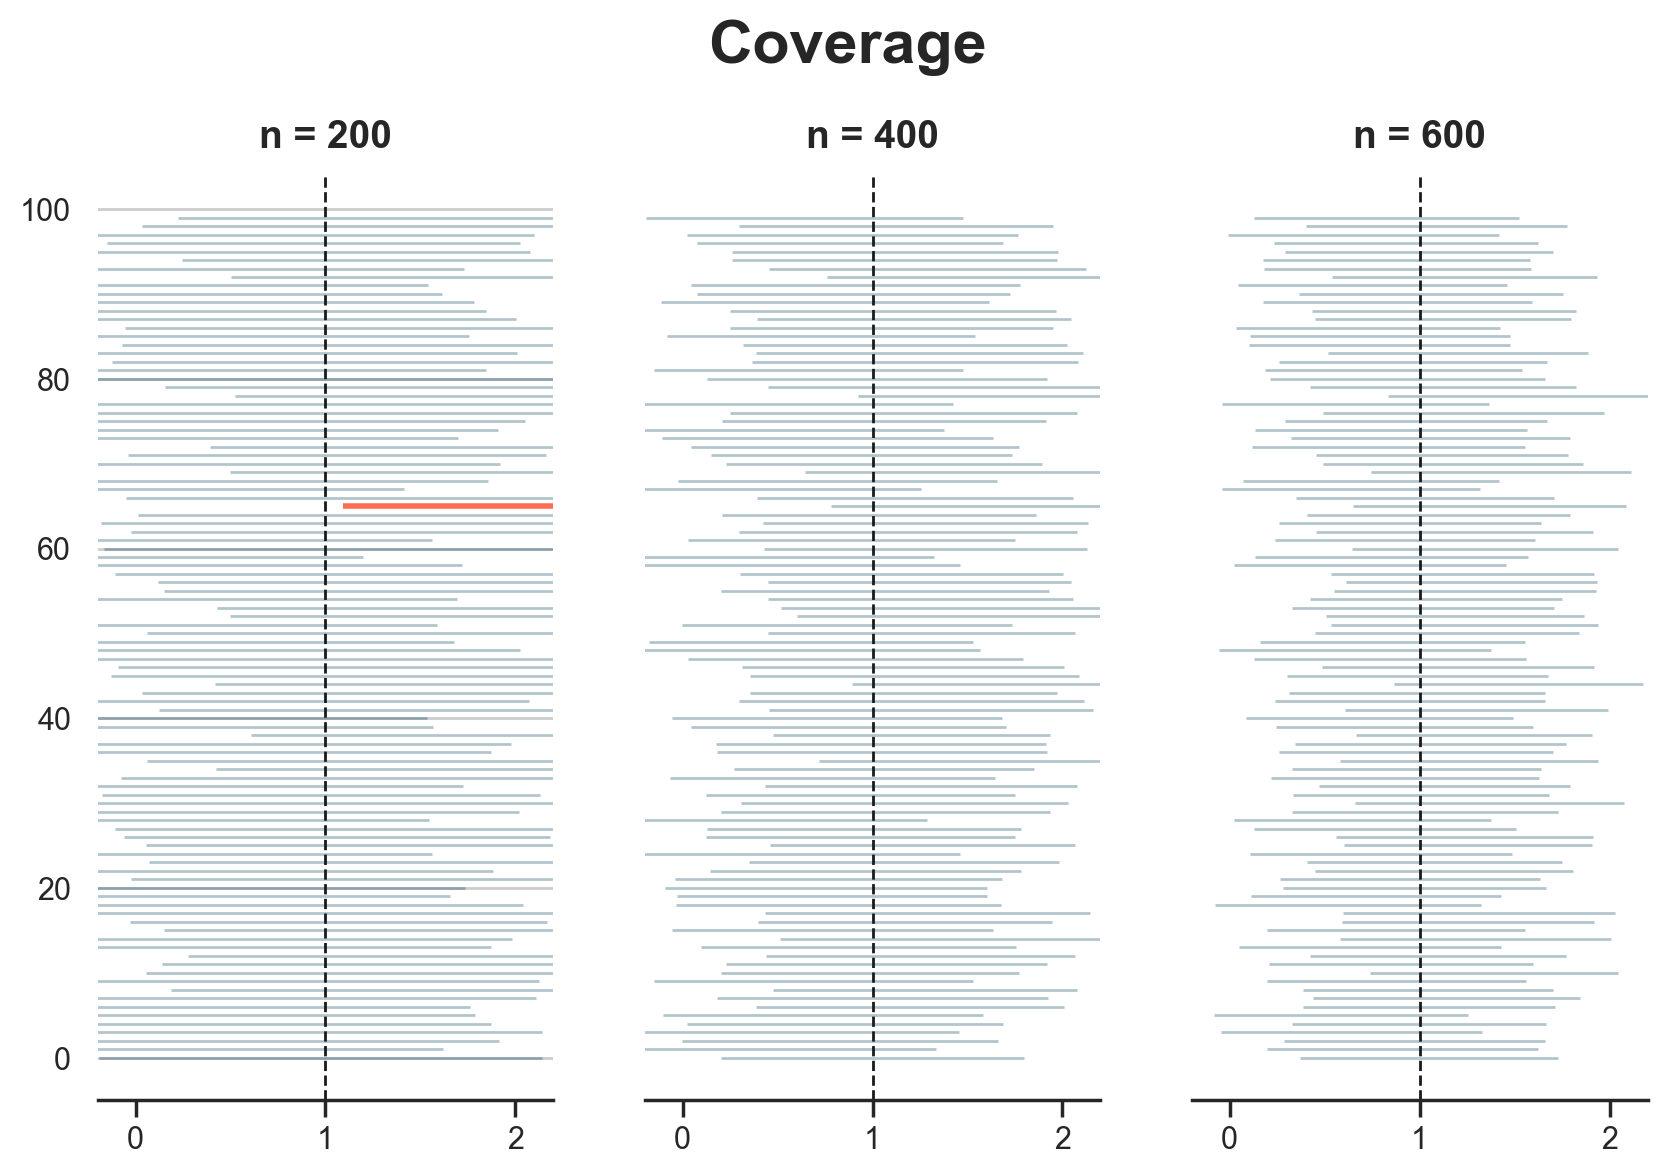

In [22]:
dfi_bonferroni = compute_intervals(select_alpha_bonferroni, obs, N_peek)
plot_intervals(dfi_bonferroni, N_plot, "coverage")

Coverage looks great! Only once at *n=200* one interval did not cover the true value *μ=1*. 

While this might appear comforting at first, it should actually raise an eyebrow. In fact, with a significance level *α=0.05* we expect a coverage of *95%*. A higher coverage will most likely come at the expense of **power**. Let's have a look.

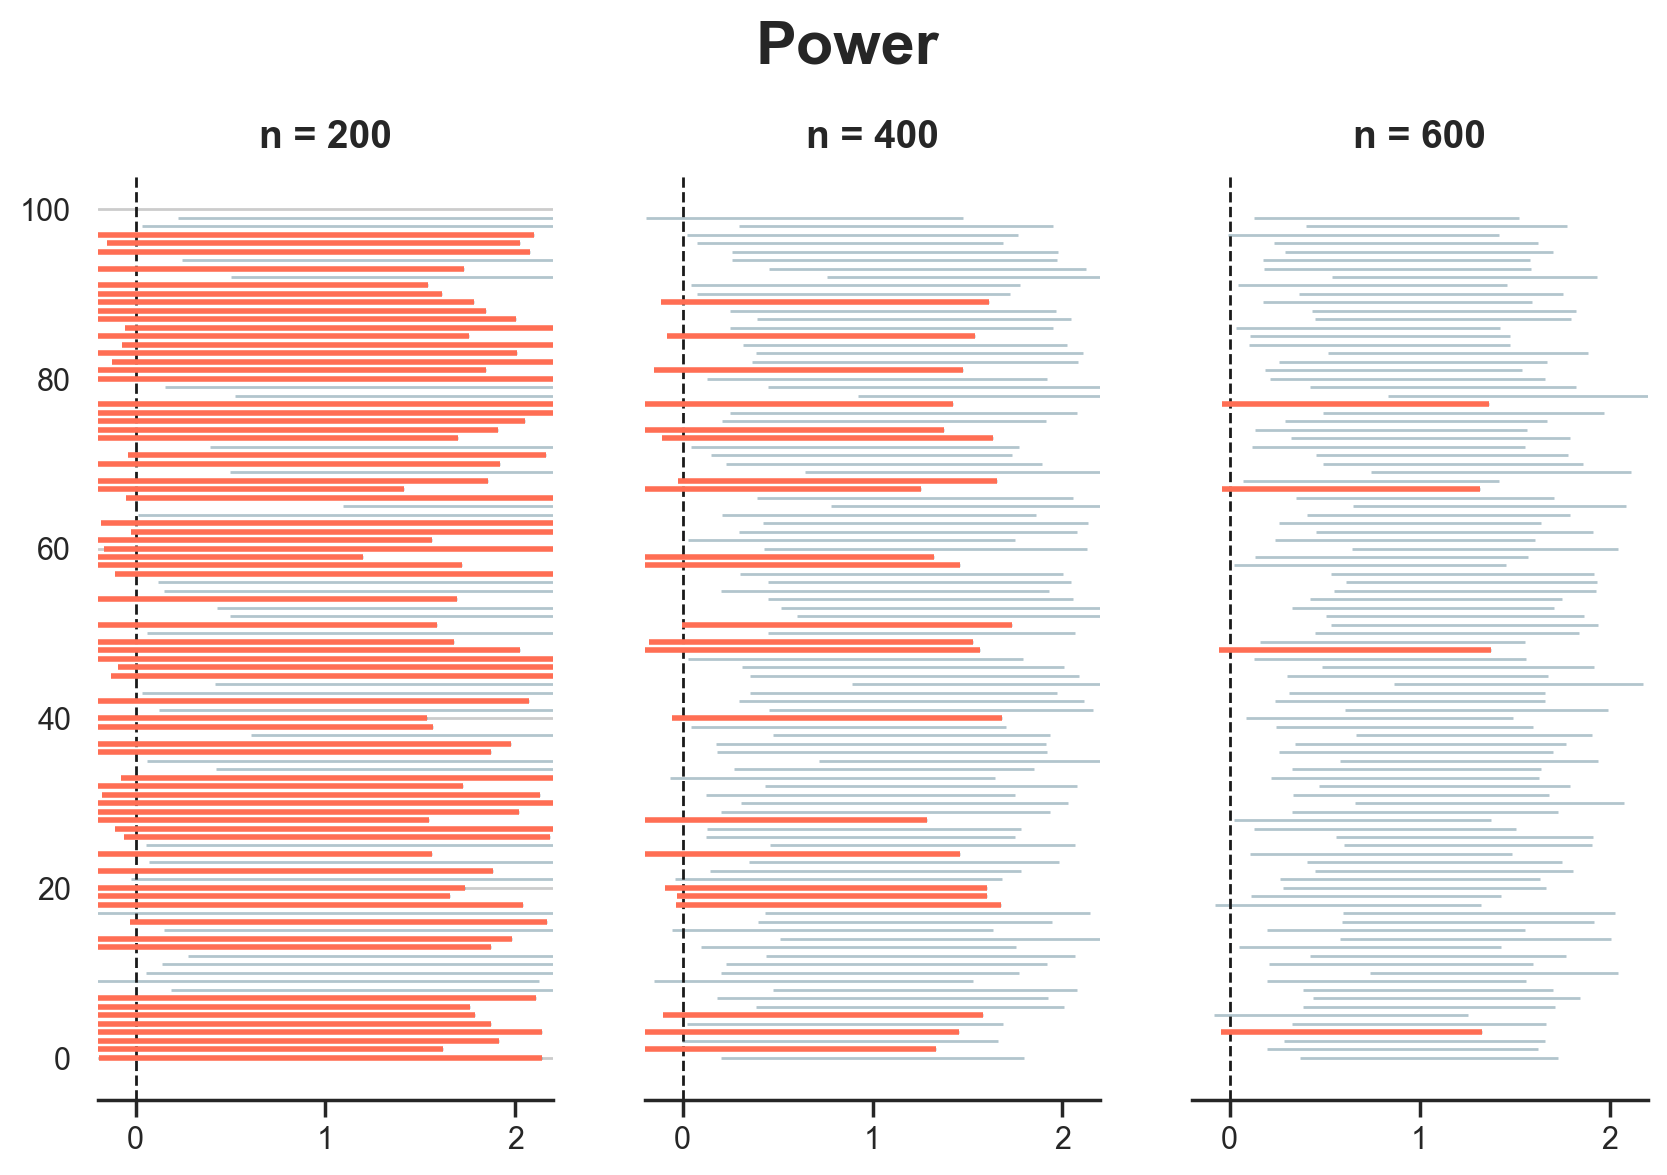

In [23]:
plot_intervals(dfi_bonferroni, N_plot, "power")

The test is clearly underpowered at *200* observations, while it is very close to the target power of *80%* at *400* observations. At *600* observations we have almost 100% power.

Let's plot coverage, power, and false positive rate for each peeking stage over *K=10,000* simulations.

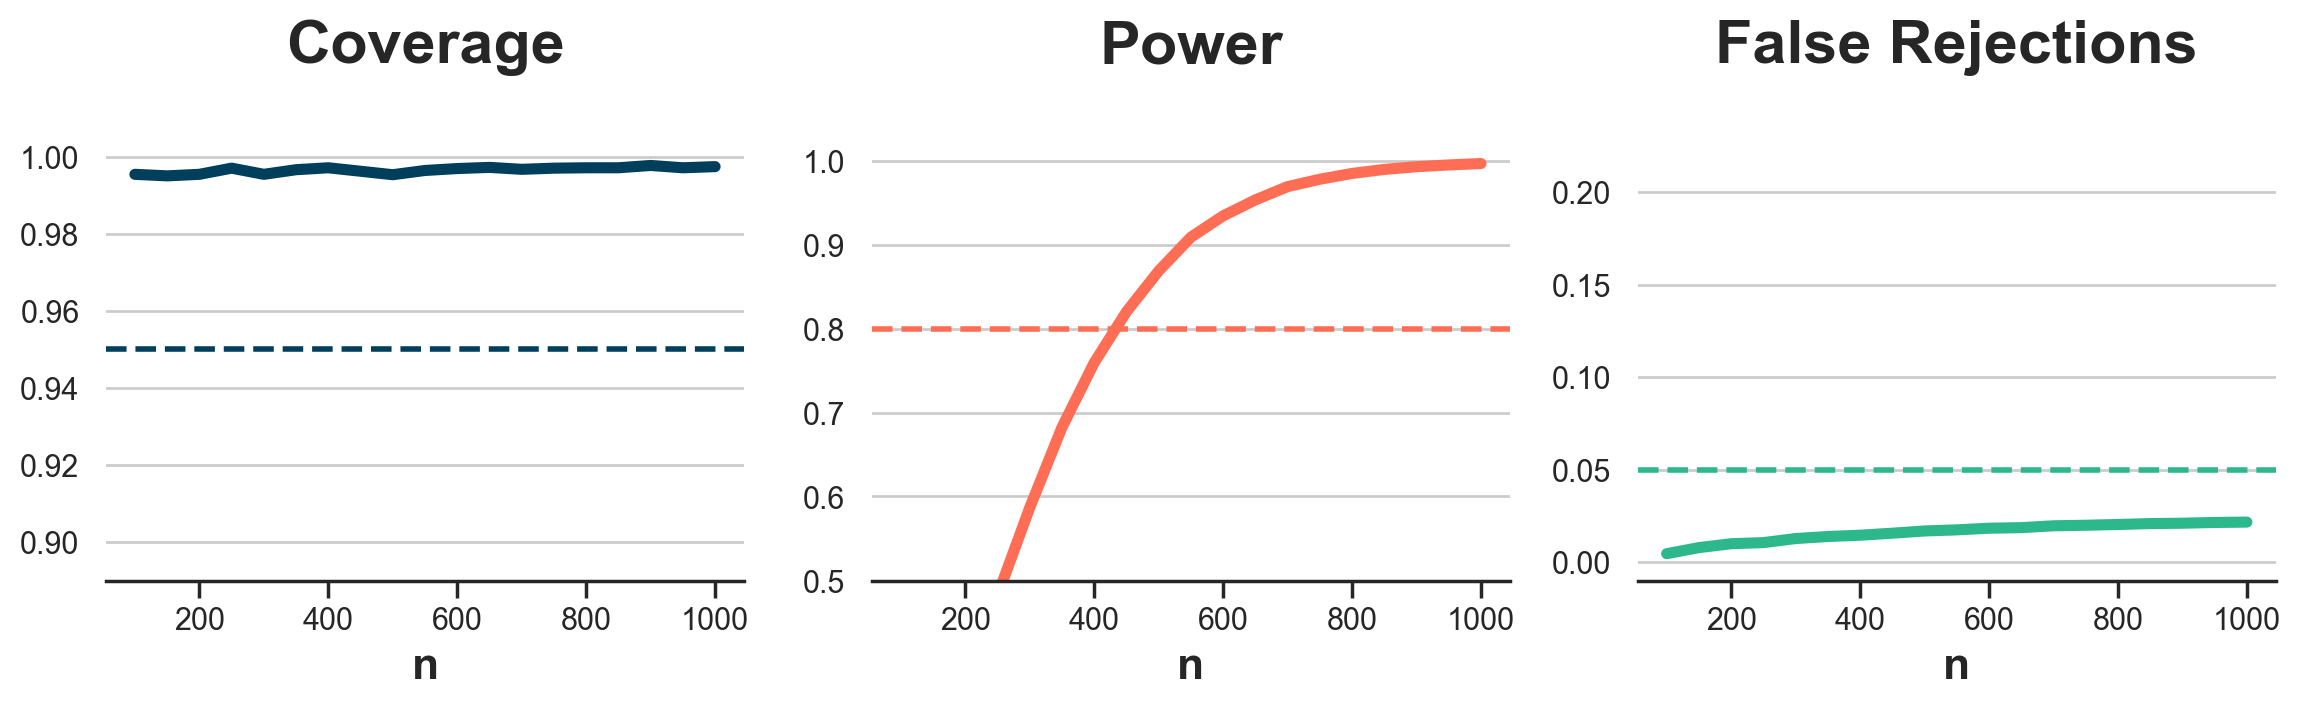

In [62]:
plot_coverage_power(dfi_bonferroni)

Coverage is great, power is above target starting at  around *450* observations, and the false rejection rate is always below the target *5%*. What about the avearge experiment length?

In [65]:
print(f"Average length: n = {dfi_bonferroni.length.mean():.0f}", )

Average length: n = 317


The average experiment length is *317* observations, higher than the naive testing procedure, but still sensibly lower than the *1000* observations without peeking. 

So, everything looks good, but maybe **too good**, in the sense that there is clearly room for improvement. Given such high coverage and low false rejection rate, the results suggest that we could have shorter confidence intervals and hence higher power and lower experiment length, without dropping below *95%* coverage or above *5%* false rejection rate. How?

The Bonferroni correction has **two drawbacks**. First, it was **not designed for sequential testing**, but rather for multiple hypothesis testing. Second, even for multiple hypothesis testing, it is known to be very **conservative**.

### Corrections

A first version of **Bonferroni's correction for sequential testing** was [Pocock (1977)](https://www.jstor.org/stable/2335684). The idea was to take into account the **sequential** nature of testing which generates a very specific correlation structure between the test statistics. Thanks to this insight, Pocock was able to use a corrected *α* value that was in between the naive *α* and Bonferroni's *α/P*. A larger *α* than Benferroni implies higher power while keeping high coverage and a low false positive rate. The values are found through a numeric algorithm that takes as input the significance level *α* and the total number of peeks *P*.

The problem with Pocock correction was that it did not fully exploit the sequential nature of the testing, since the confidence intervals were constant over time. [O’Brien, Fleming (1979)](https://www.jstor.org/stable/2530245) proposed to use **time-varying** *α* corrections. Their idea was to adapt the width of the confidence interval not only to the significance level *α* and the total number of peeks *P*, but also the individual peek *p*. 

However, the main drawback of all these procedures is that they require to **plan** the number of peeks in advance. This is often *not practical*, since peeking is an inherently spontaneous process, that comes from either the size of the data batch, pressure from management, or simply the experimenter's curiosity. 

What can we do when peeking is **not planned** in advance?

## Group Sequential Testing

[Lan, DeMets (1983)](https://www.jstor.org/stable/2336502) noticed that the important thing in peeking is not *how much* you peek, but rather *when* you peek. The main idea of **Group Sequential Testing (GST)** is to allow for peeking at any point in time, and correct the significance level for the peeking point in time in the data collection process, *t = n/N*.

The moving part of group sequential testing is the so-called **alpha spending function** that determines how to correct the significance level *α*, given peeking time *t*. In the rest of the article we are going to review two alpha spending functions that approximate the corrections of [Pocock (1977)](https://www.jstor.org/stable/2335684) and [O’Brien, Fleming (1979)](https://www.jstor.org/stable/2530245), respectively.

### GST Pocock Approximation

The first alpha-spending function is an approximation of [Pocock (1977)](https://www.jstor.org/stable/2335684) and it is given by

$$
f(\alpha, t) = \alpha \ln \big( 1 + (e - 1) t \big)
$$

Note that as the share of observations *t=n/N* reaches the full sample (*t=1*), Pocock's correction converges to the original significance level *α*.

In [78]:
def select_alpha_gst_pocock(n, N, N_peek, alpha):
    t = n / N
    return alpha * np.log(1 + (np.exp(1) - 1) * t)

Let's see how group sequential testing using Pocock's alpha spending function works.

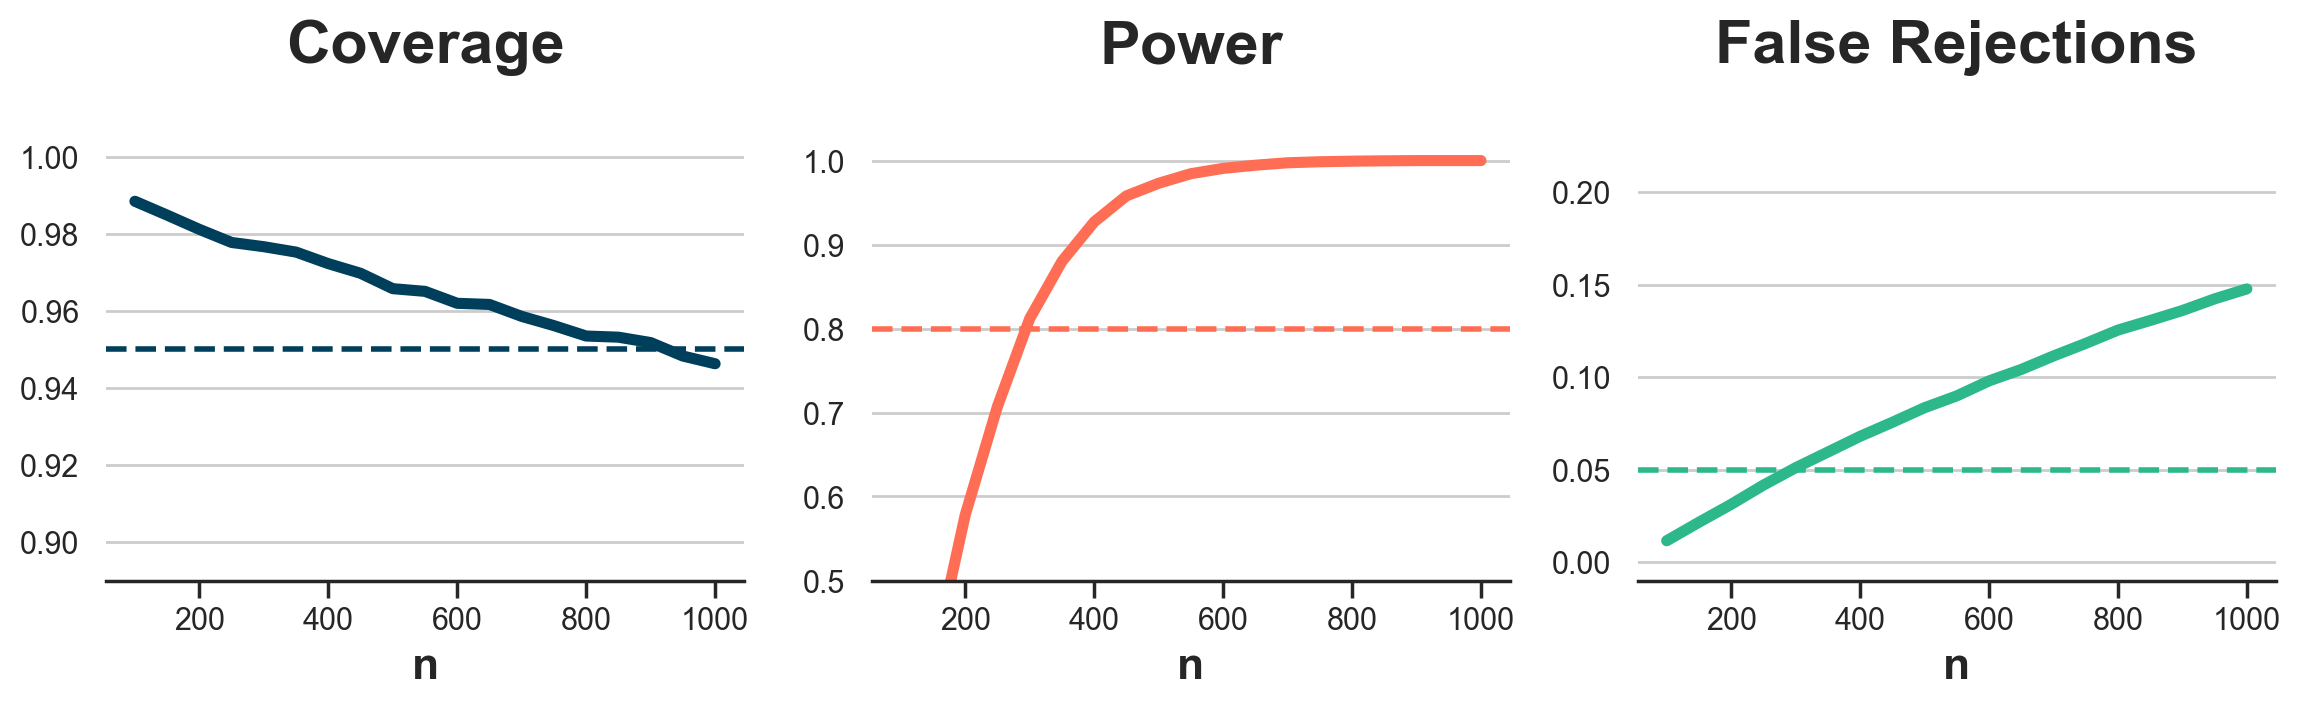

In [79]:
dfi_gst_pocock = compute_intervals(select_alpha_gst_pocock, obs, N_peek)
plot_coverage_power(dfi_gst_pocock)

As we noted before, coverage converges to the target coverage and the number of observations increases. The experiment seems also to be better powered than using Bonferroni's correction, but the false rejection rate increases above the target *5%* if the experiment runs too long.

What about the expected experiment length?

In [77]:
print(f"Average length: n = {dfi_gst_pocock.length.mean():.0f}", )

Average length: n = 229


The expected length in indeed lower than Boferroni, with an average of *229* observations instead of *317*.

### GST O’Brien & Fleming Approximation

The second alpha-spending function is an approximation of [O’Brien, Fleming (1979)](https://www.jstor.org/stable/2530245) and is given by

$$
f(\alpha, t) = 4 - 4 \Phi \Big( \Phi^{-1} \big(1 - \alpha/4 \big) \ / \ t^{\rho/2} \Big)
$$

where **Φ** is the cumulative distribution function (CDF) of a standard normal distribution, and *ρ* is a free parameter that is usually defaulted to *ρ=1*.

In [74]:
def select_alpha_gst_obrien_fleming(n, N, N_peek, alpha, rho=1):
    t = n / N
    return 4 - 4 * cdf(ppf(1 - alpha/4) / t**(rho/2))

Let's see how group sequential testing using O'Brien and Fleming approximation performs over *K=10,000* simulations.

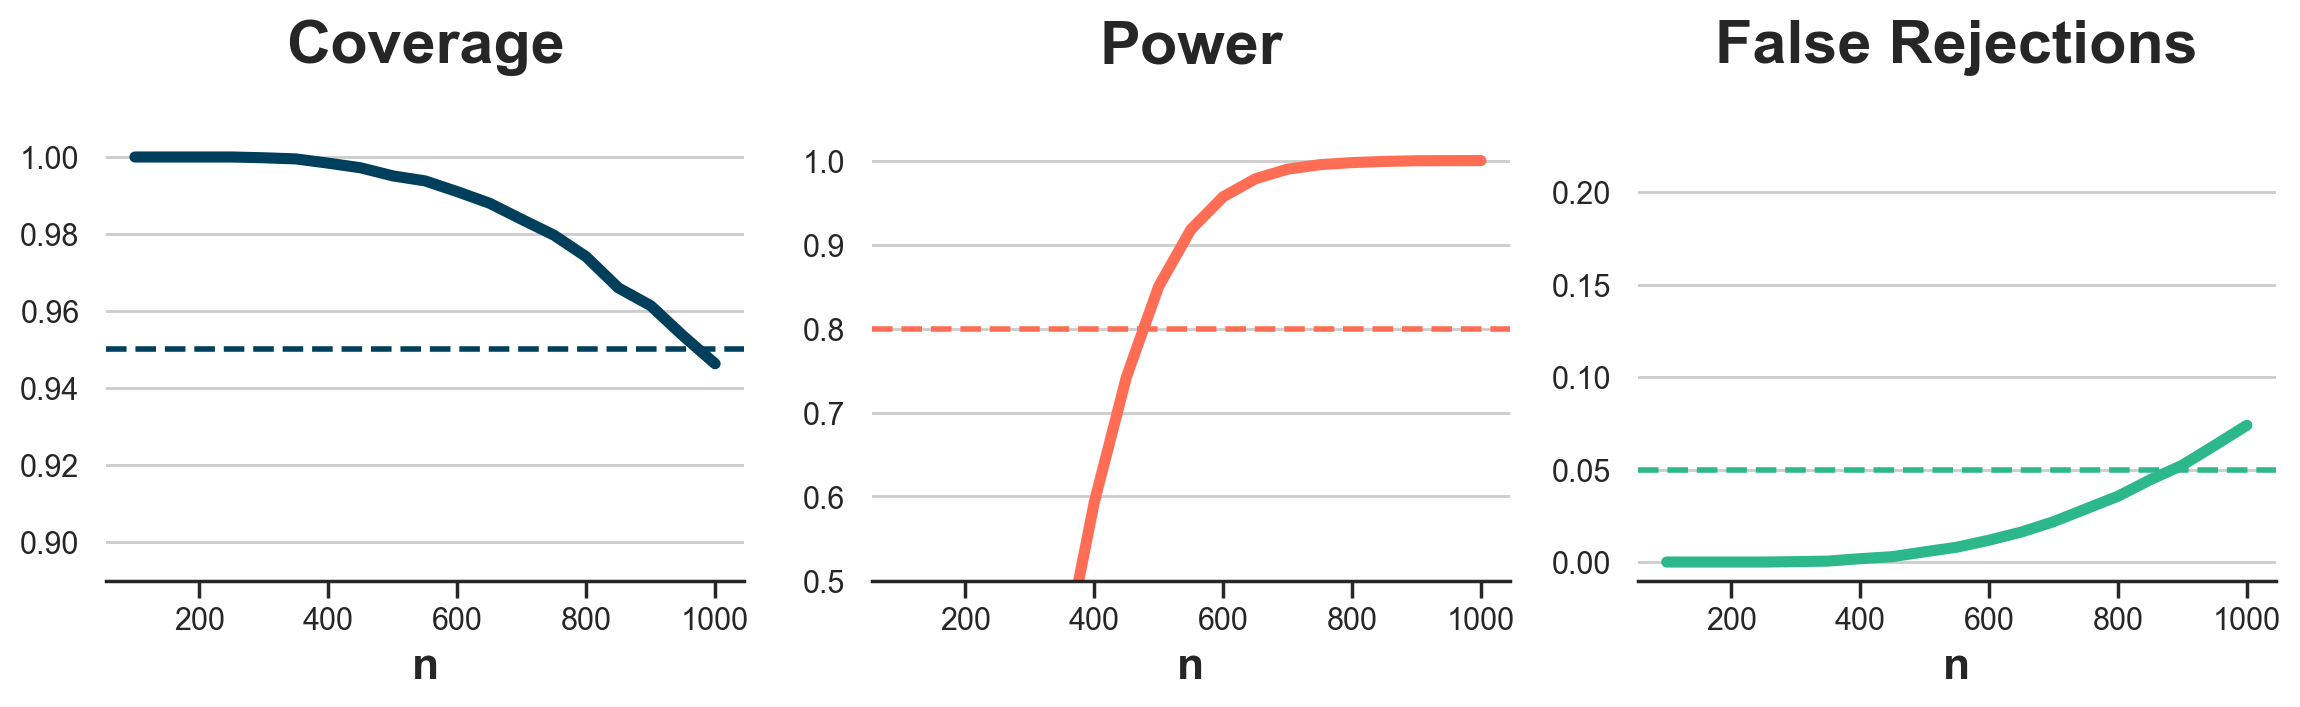

In [75]:
dfi_gst_obrien_fleming = compute_intervals(select_alpha_gst_obrien_fleming, obs, N_peek)
plot_coverage_power(dfi_gst_obrien_fleming)

It seems that the O’Brien and Fleming approximation is more conservative than Pocock's, with a higher coverage and lower power, but keeping the false rejection rate closer to the *5%* target.

In [76]:
print(f"Average length: n = {dfi_gst_obrien_fleming.length.mean():.0f}", )

Average length: n = 414


The expected length is actually higher than Boferroni, with an average of *414* observations instead of *317*. However, it can be lowered by decreasing the parameter *ρ* in the correction formula. Let's use for example *ρ=0.5* which corresponds to [Wang, Tsiatis (1987)](https://www.jstor.org/stable/2531959) correction.

In [82]:
dfi_gst_obrien_fleming_05 = compute_intervals(select_alpha_gst_obrien_fleming, obs, N_peek, rho=0.5)
print(f"Average length: n = {dfi_gst_obrien_fleming_05.length.mean():.0f}", )

Average length: n = 303


Indeed, with a lower *ρ* we have decrease the average experiment length from *414* to *303* observations.

## Alpha Spending Trade-off

Before concluding, it is worth having a look at the peeking trade-offs. We have introduced a method that allows us to do valid inference while peeking any number of times, whenever we feel like. But **should we peek**? And, if so, **how much**?

In the figure below, I plot the testing performance using group sequential testing with Pocock's approximation, when we **increase the peeking frequency** from *50* to *10* observations.

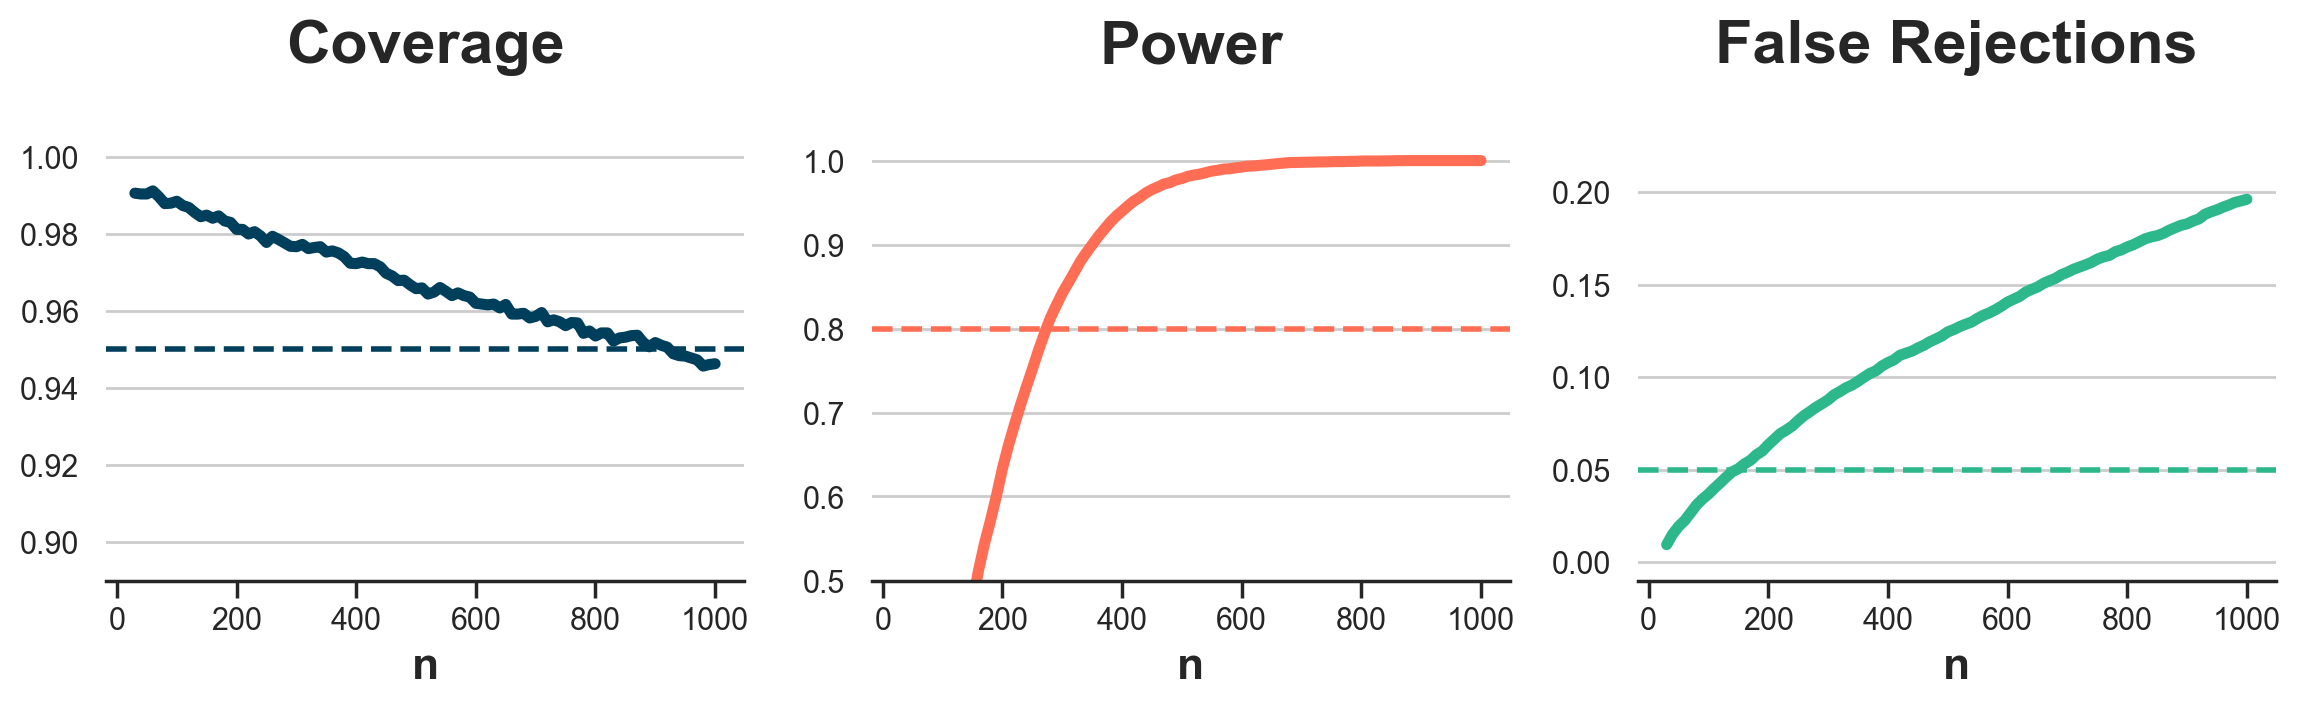

In [87]:
N_peek_10 = np.arange(30, N+1, 10, dtype=int)
dfi_gst_10 = compute_intervals(select_alpha_gst_pocock, obs, N_peek_10)
plot_coverage_power(dfi_gst_10)

As we can see, coverage is basically unaffected, while power and false rejections have increased. The average experiment length has also decreased from *229* to *188* observations.

In [89]:
print(f"Average length: n = {dfi_gst_10.length.mean():.0f}", )

Average length: n = 188


What if instead we **reduced the peeking frequency**? In the figure below, I plot the results when peeking every 200 observations.

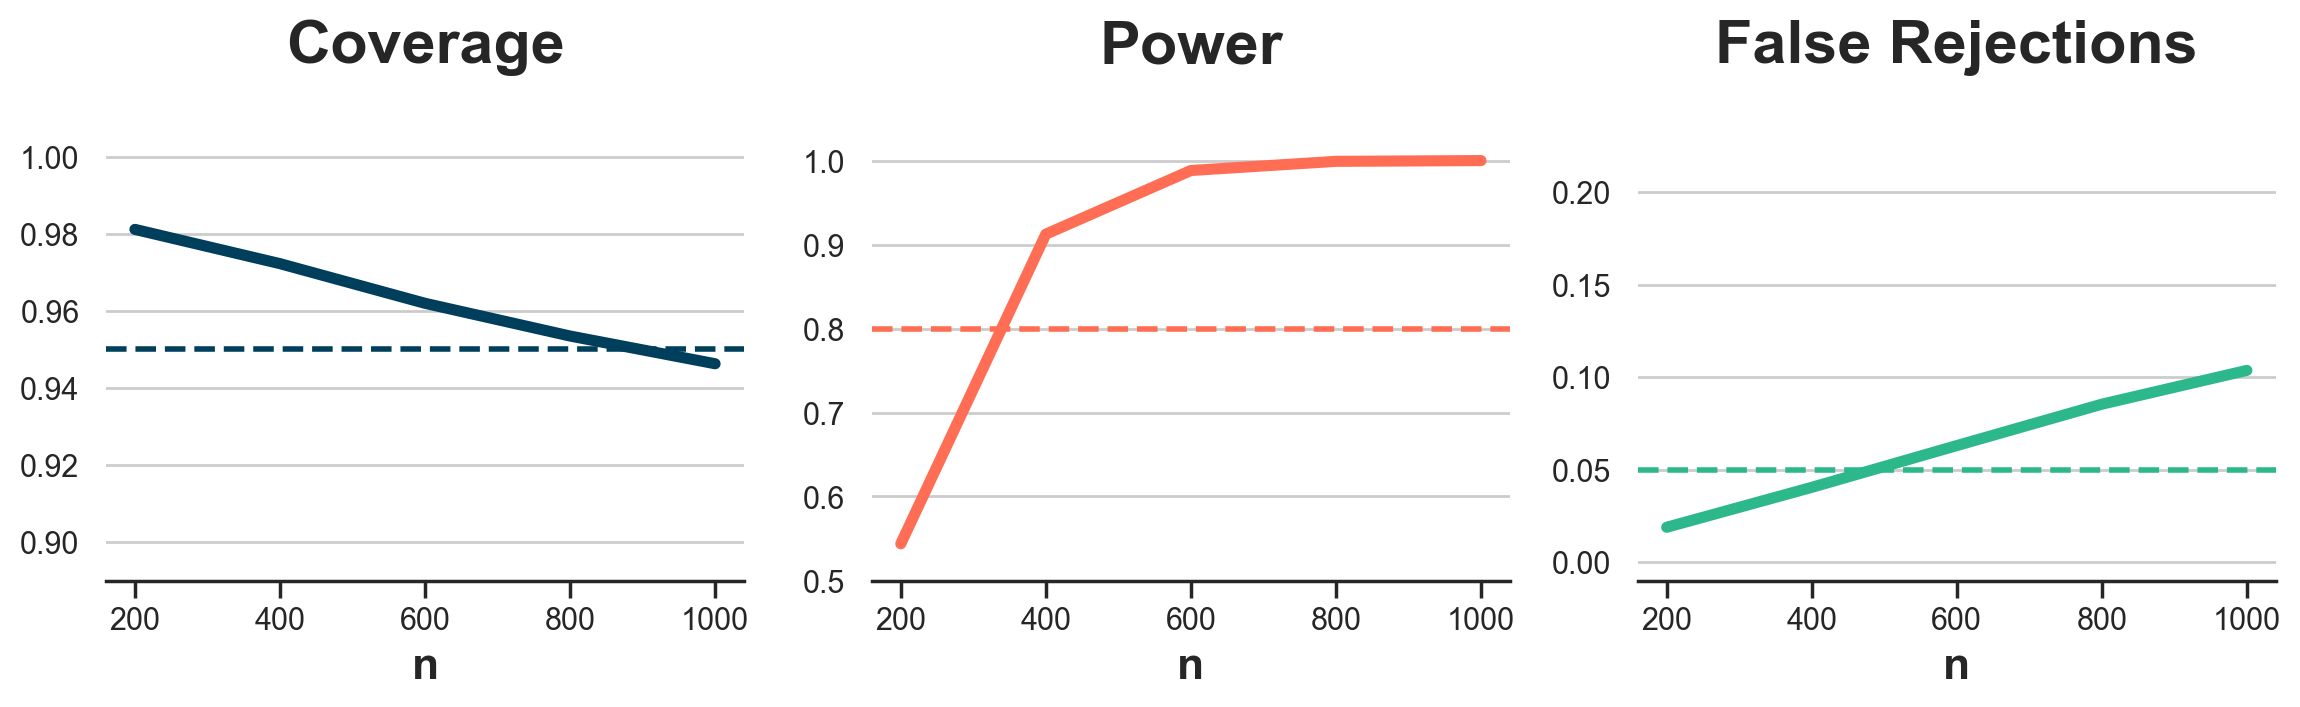

In [85]:
N_peek_200 = np.arange(200, N+1, 200, dtype=int)
dfi_gst_200 = compute_intervals(select_alpha_gst_pocock, obs, N_peek_200)
plot_coverage_power(dfi_gst_200)

From the figure, we see the opposite result: power and false rejections have decreased. On the other hand, we now need on average *313* observations to reach a conclusion instead of *229*.

In [90]:
print(f"Average length: n = {dfi_gst_200.length.mean():.0f}", )

Average length: n = 311


## Conclusion

In this article, we have explored **group sequential testing**, a procedure to do valid inference when peeking during an A/B test, any number of times, and at any point during the experiment. We have also seen how peeking does not come for free. The main **trade-off** is that the more we peek, the earlier we can stop an experiment but also the higher the false rejection rate.

There are at least a couple of topics that I have not mentioned in the article, not to make it too long. The first one is **bias**. Sequential tests can easily introduce bias since early stopping could be due to either a low variance or a large effect. Because of the second, sequential tests can often lead to the *overestimation* of treatment effects. This phenomenon is often called the *winner's curse* and typically occurs when the study is underpowered, which is happens at the early peeking stages. One solution is to design a **beta spending** function.

The second topic that I didn't cover is what is called **stopping for futility**. In the examples of this article, we stopped experiments early if we got a statistically significant estimate. However, peeking can also inform a different stopping rule: stopping because it becomes extremely unlikely that continuing the test can produce significant results.

One last topic I have not covered is how to do **power analysis** with sequential testing. In the example above, we ran the power analysis at the very beginning assuming no peeking. However, given that we knew we would have peeked, we could have anticipated the need for a smaller sample. A closely related topic is **optimal peeking**. Once you decide to peek, when should you do it? 

## References

- Lakens, Pahlke, Wassmer (2021). [Group Sequential Designs: A Tutorial](https://osf.io/preprints/psyarxiv/x4azm)
- Lan, DeMets (1983). [Discrete Sequential Boundaries for Clinical Trials](https://academic.oup.com/biomet/article-abstract/70/3/659/247777)
- Spotify (2023). [Choosing a Sequential Testing Framework](https://engineering.atspotify.com/2023/03/choosing-sequential-testing-framework-comparisons-and-discussions/)

### Related Articles

- [Experiments, Peeking, and Optimal Stopping](https://towardsdatascience.com/954506cec665)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/group_sequential_testing.ipynb